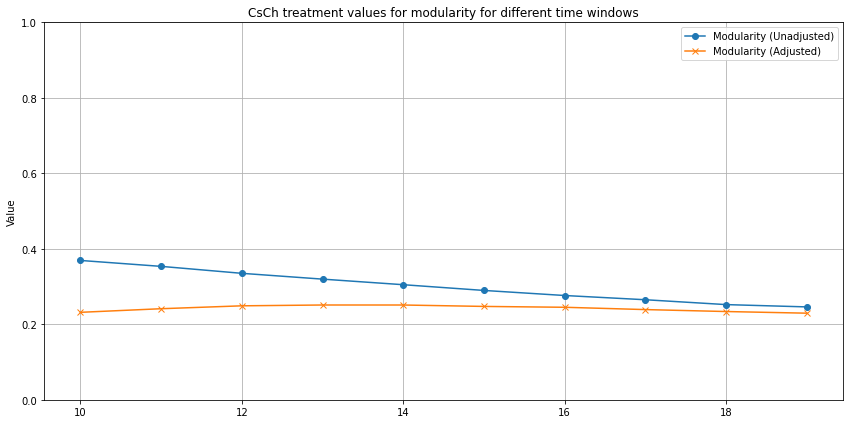

CsCh: Max modularity is 0.251188638021279 at time window 13


SystemExit: 

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
#%%
import os, sys

from networkx.algorithms.community import modularity
from networkx.algorithms.community import greedy_modularity_communities

import matplotlib.pyplot as plt
import networkx as nx

import networkx as nx
import pandas as pd

from src import settings
from src.utils import fileio


count_graphs = {}

for TREATMENT in ['CsCh', 'CS_10D', 'Cs_5DIZ', 'LDA_5DIZ', 'LDA_OCT_5DIZ']:

    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "1_0_find_interactions", TREATMENT)
    main_config = fileio.get_config(settings.CONFIG_NAME)

    time_windows_all = list(range(10, 20))

    res_dict_q = {}
    res_dict_qadj = {}

    res_dict_q_duration = {}
    res_dict_q_count = {}

    all_graph_objects = {}
    for TIME_WINDOW in time_windows_all:
        TIME_WINDOW_FPS = TIME_WINDOW * main_config["FPS"]

        treatment = fileio.load_files_from_folder(INPUT_DIR)

        Q_all = []
        Qadj_all = []
        Q_all_count = []
        Q_all_duration = []
        
        for group_name, group_path in treatment.items():
            df_interactions = pd.read_csv(group_path, index_col=0)
            df_interactions = df_interactions.sort_values("start_of_interaction")
            df_interactions["snapshot"] = df_interactions["start_of_interaction"] // TIME_WINDOW_FPS
            df_interactions["snapshot"] = df_interactions["snapshot"] + 1

            all_graphs = []
            for i in range(1, df_interactions["snapshot"].max() + 1):
                df_snapshot = df_interactions[df_interactions["snapshot"] == i]
                G = nx.DiGraph()
                G.add_nodes_from([f"fly{i}" for i in range(1, 13)]) 
                
                for _, row in df_snapshot.iterrows():
                    node_1, node_2 = row["node_1"], row["node_2"]
                    duration = row["duration"]

                    if G.has_edge(node_1, node_2):
                        G[node_1][node_2]["count"] += 1
                        G[node_1][node_2]["interaction_times_list"].append(duration)
                        G[node_1][node_2]["total_interaction_times"] += duration

                    else:
                        G.add_edge(node_1, node_2, count=1, total_interaction_times=duration,
                                interaction_times_list=[duration])
                        
                all_graphs.append(G)
            
            all_graph_objects[TIME_WINDOW] = all_graphs
            count_graphs[TIME_WINDOW] = len(all_graphs)
    # sys.exit()

            for i, g in enumerate(all_graphs[:-1]):
                num_isolated = len(list(nx.isolates(g)))

                num_components = nx.number_connected_components(g.to_undirected())
                sub_graphs = num_components - num_isolated

                if num_isolated == 12:
                    PR = 0
                    Q_all.append(0)
                    Qadj_all.append(0)
                else:
                    PR = (12 - num_isolated) / 12
                    communities = list(greedy_modularity_communities(g.to_undirected()))  
                    Q = modularity(g, communities)
                    Q_adj = Q * PR * (1/sub_graphs)
                    Q_all.append(Q)
                    Qadj_all.append(Q_adj)

                    # Q_count = modularity(g, communities, weight='count')
                    # # Q_all_count.append(Q_count * PR * (1/sub_graphs))
                    # Q_all_count.append(Q_count)
                    # Q_duration = modularity(g, communities, weight='duration')
                    # # Q_all_duration.append(Q_duration * PR * (1/sub_graphs))    
                    # Q_all_duration.append(Q_duration)

            
        res_dict_q[TIME_WINDOW] = sum(Q_all) / len(Q_all)
        res_dict_qadj[TIME_WINDOW] = sum(Qadj_all) / len(Qadj_all)
        # res_dict_q_duration[TIME_WINDOW] = sum(Q_all_count) / len(Q_all_count)
        # res_dict_q_count[TIME_WINDOW] = sum(Q_all_duration) / len(Q_all_duration)

    x = sorted(res_dict_q.keys())
    y_q = [res_dict_q[k] for k in x]
    y_qadj = [res_dict_qadj[k] for k in x]

    # y_duration = [res_dict_q_duration[k] for k in x]
    # y_count = [res_dict_q_count[k] for k in x]

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_q, label='Modularity (Unadjusted)', marker='o')
    plt.plot(x, y_qadj, label='Modularity (Adjusted)', marker='x')
    # plt.plot(x, y_duration, label='Duration (per window)', marker='s')
    # plt.plot(x, y_count, label='Count (per window)', marker='d')

    # plt.xlabel('Key (1 to 120)')
    plt.ylabel('Value')
    plt.title(f'{TREATMENT} treatment values for modularity for different time windows')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(0,1)
    # plt.savefig('test_5.png')
    plt.show()

    max_key = max(res_dict_qadj, key=res_dict_qadj.get)
    max_value = res_dict_qadj[max_key]

    print(f"{TREATMENT}: Max modularity is {max_value} at time window {max_key}")

    sys.exit()

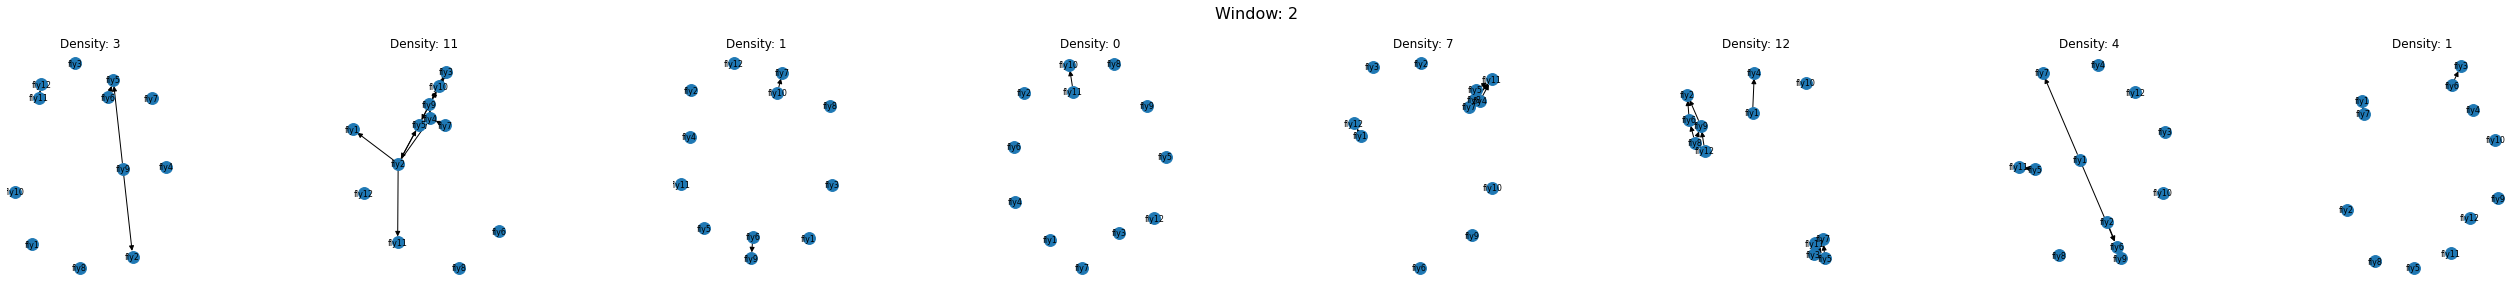

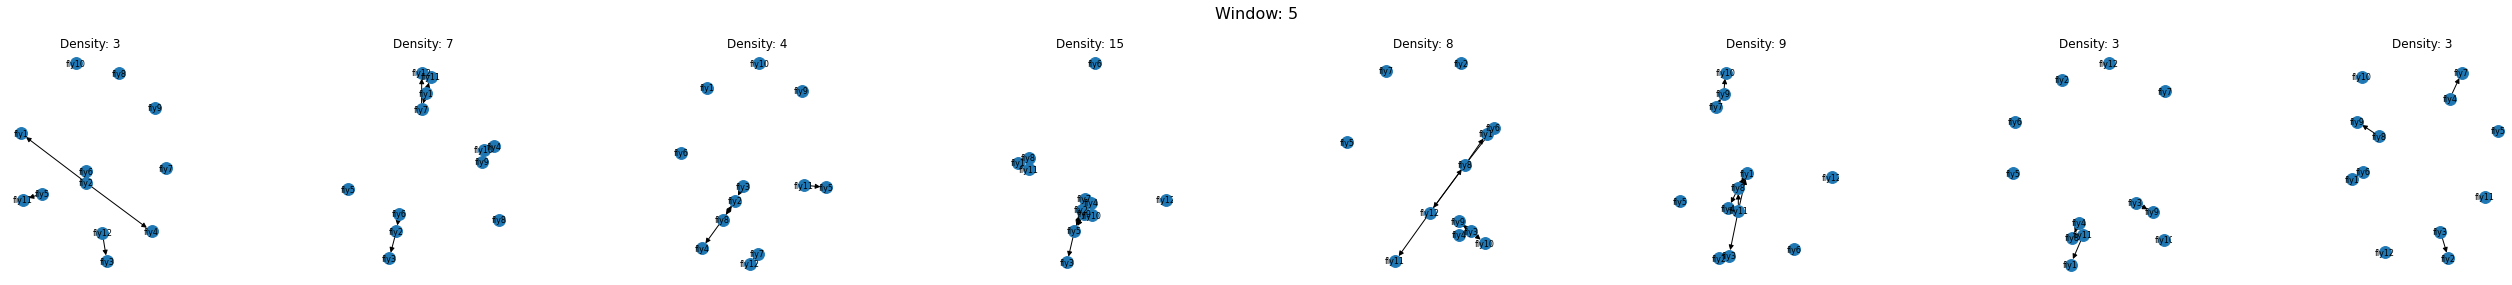

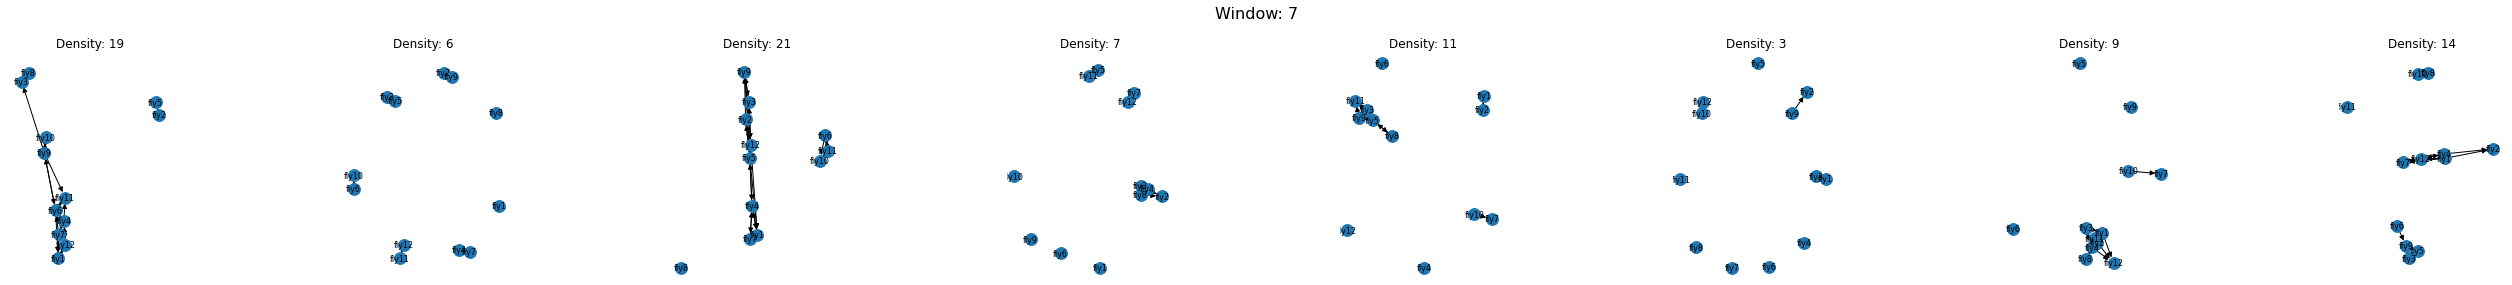

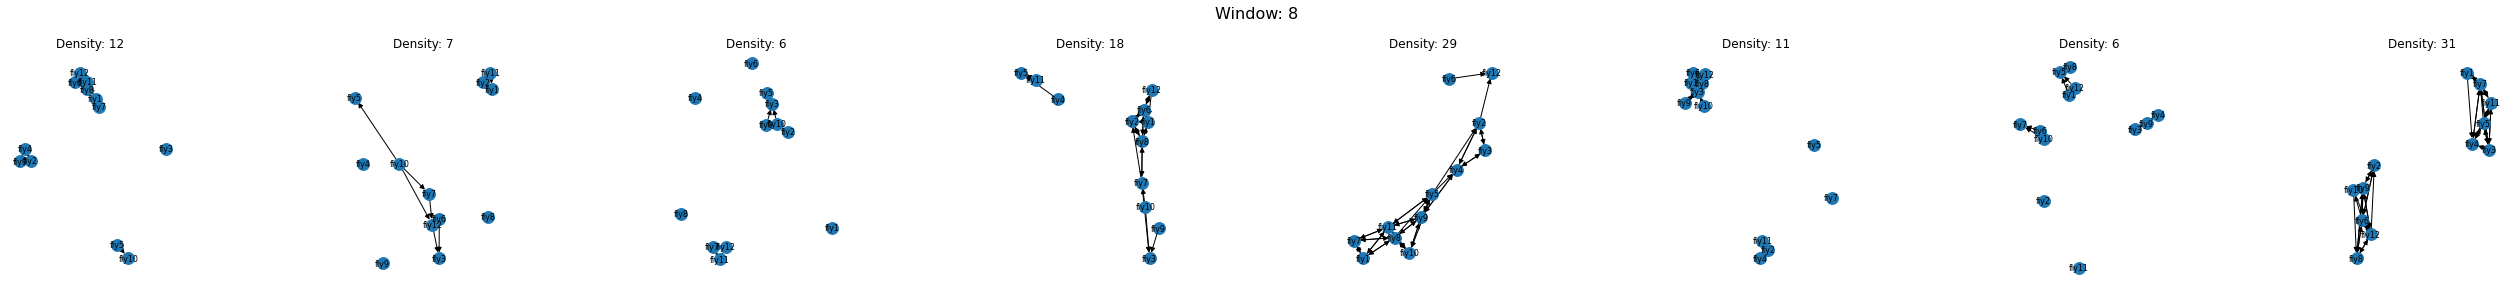

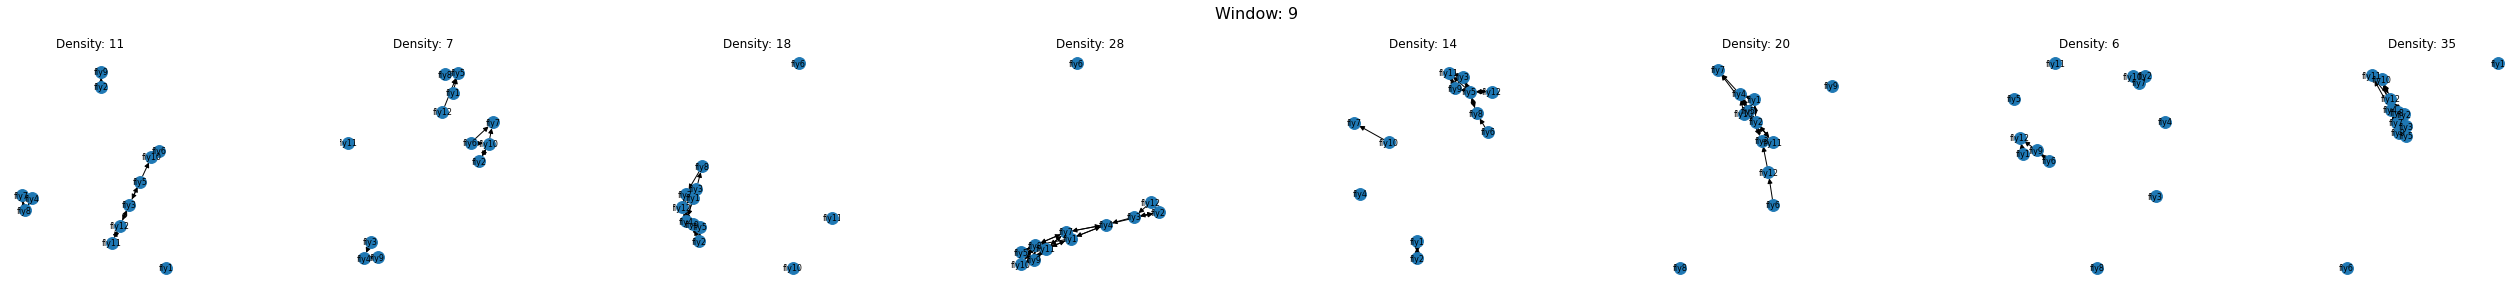

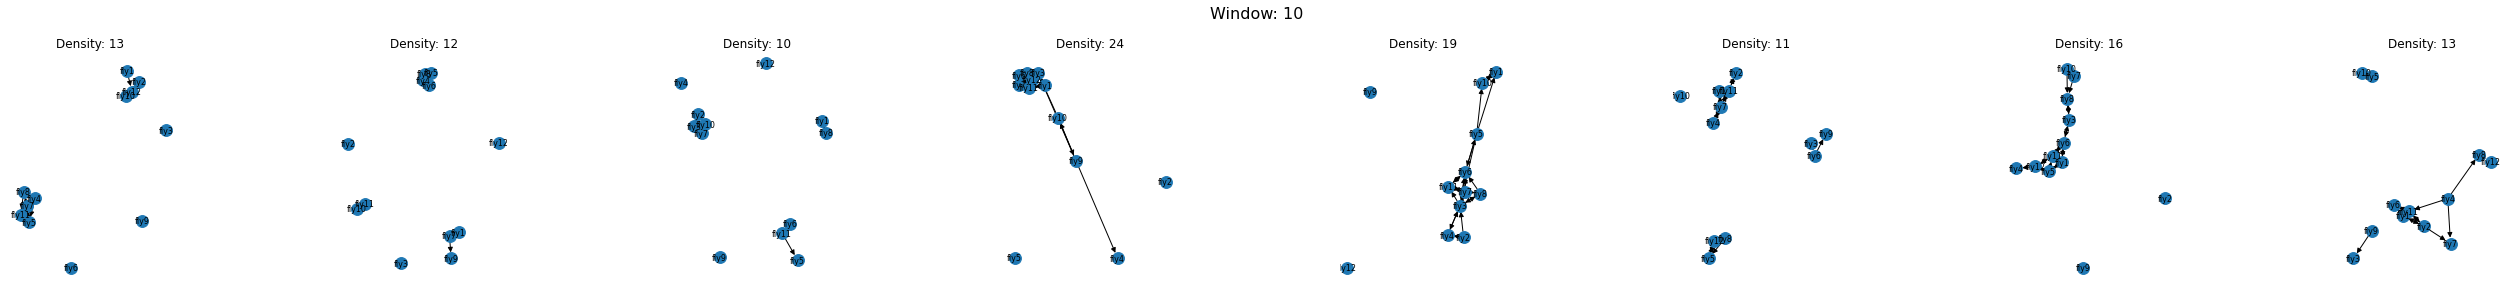

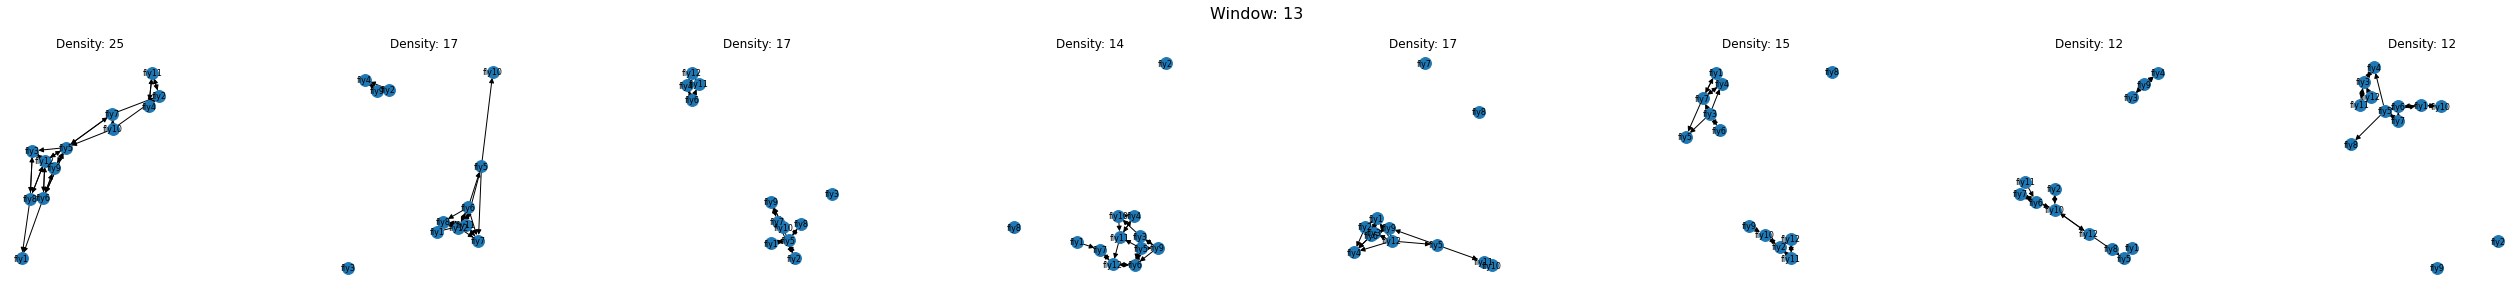

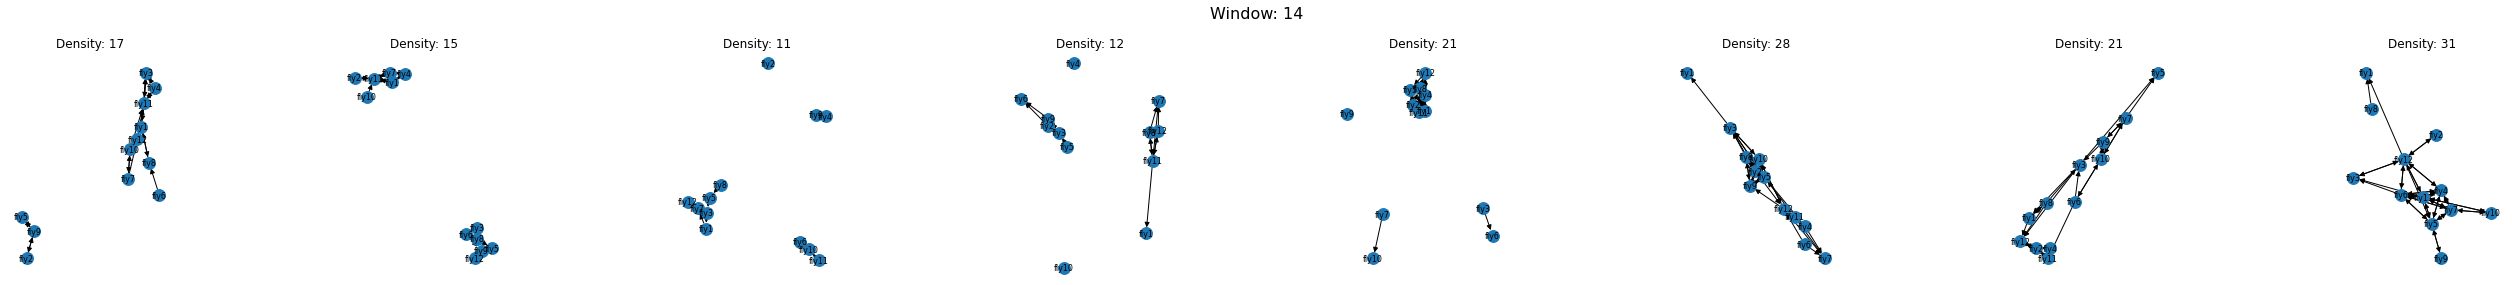

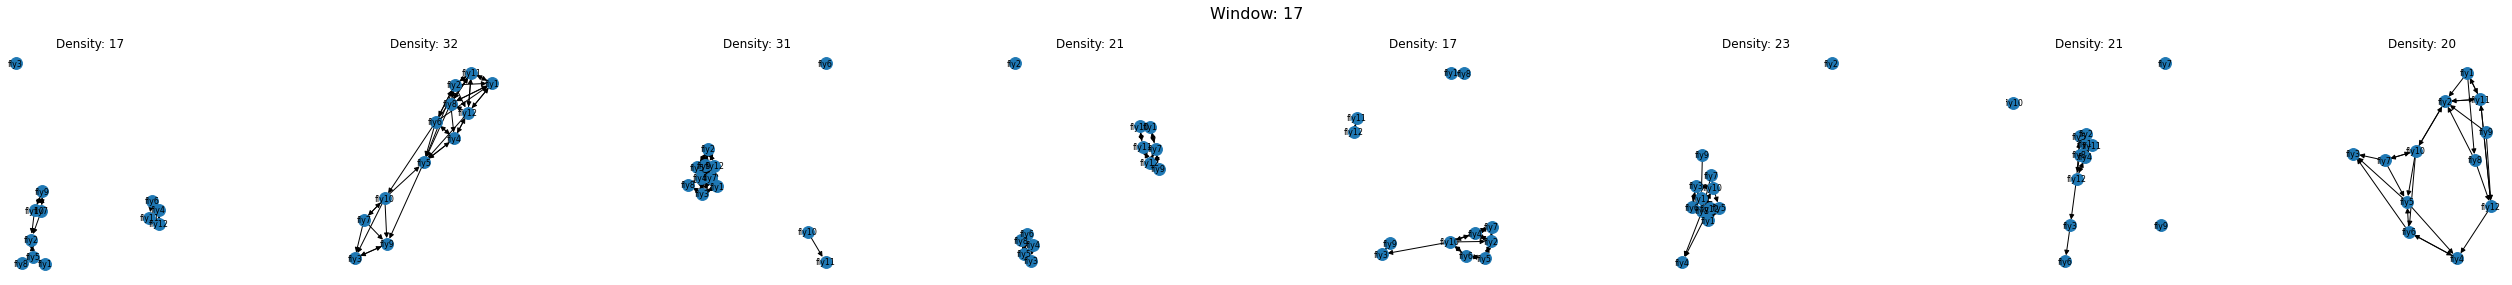

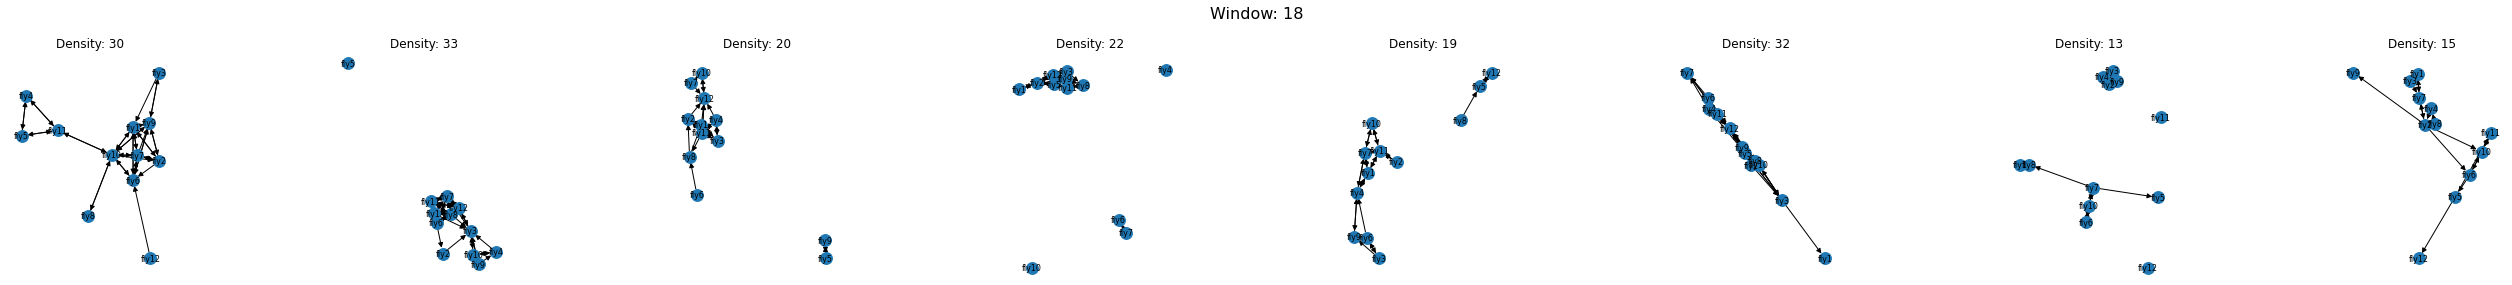

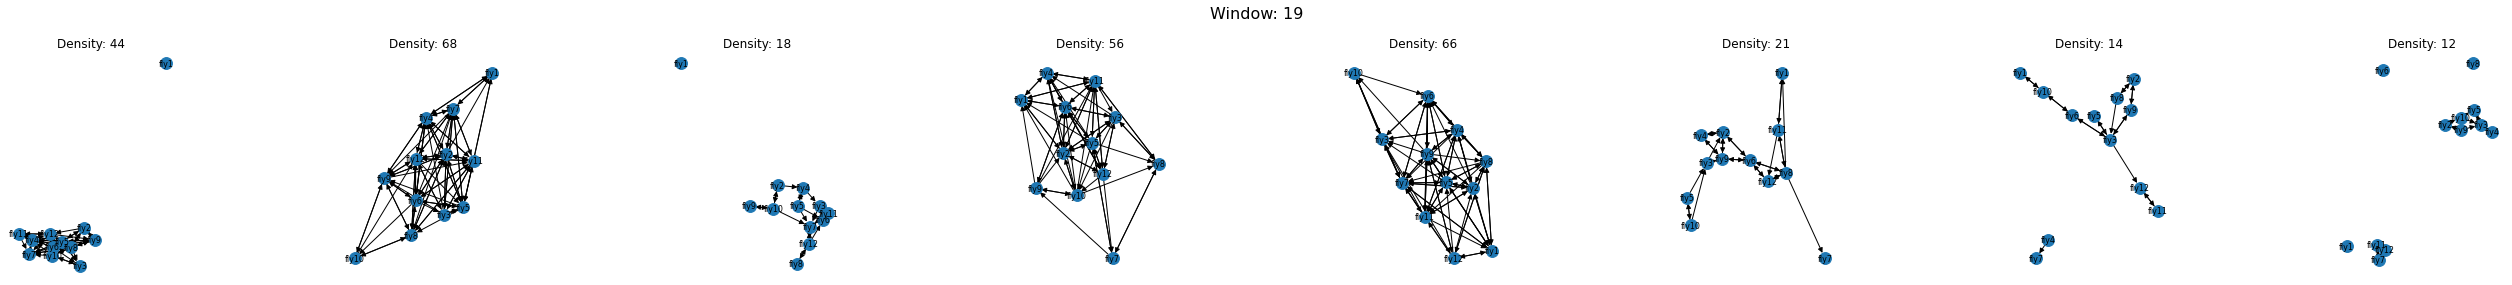

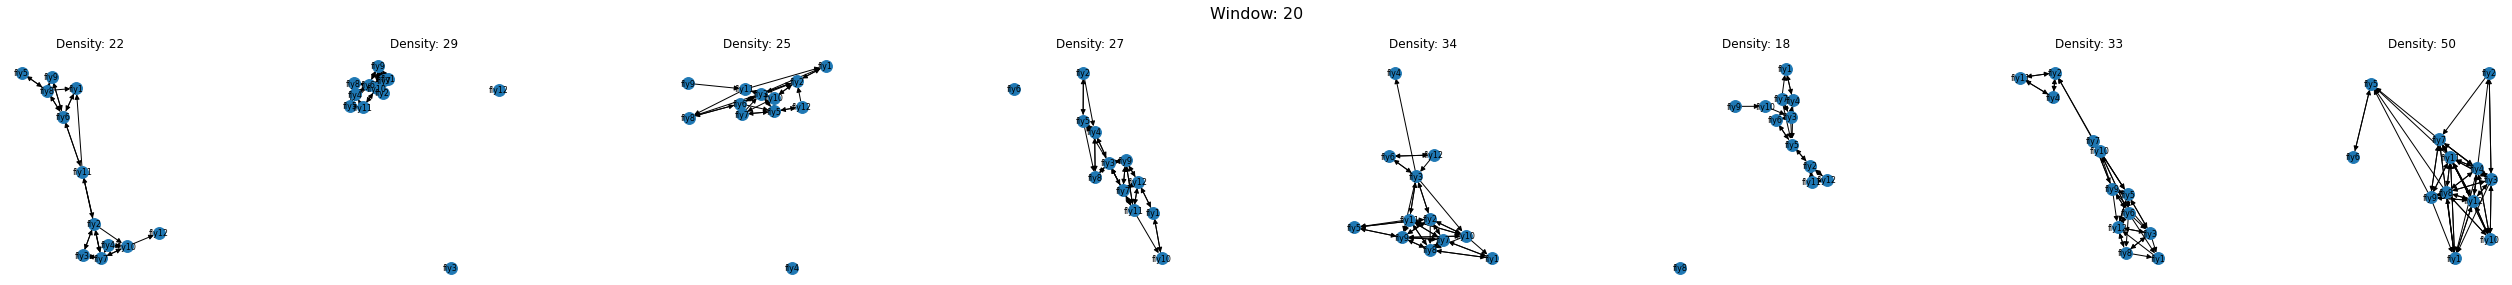

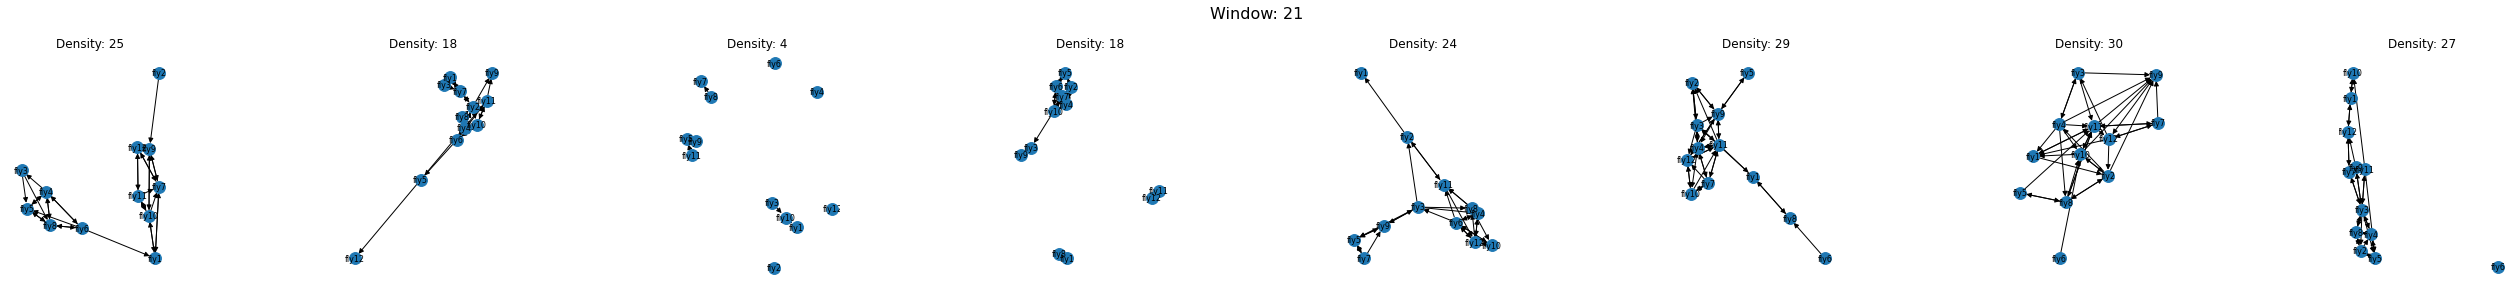

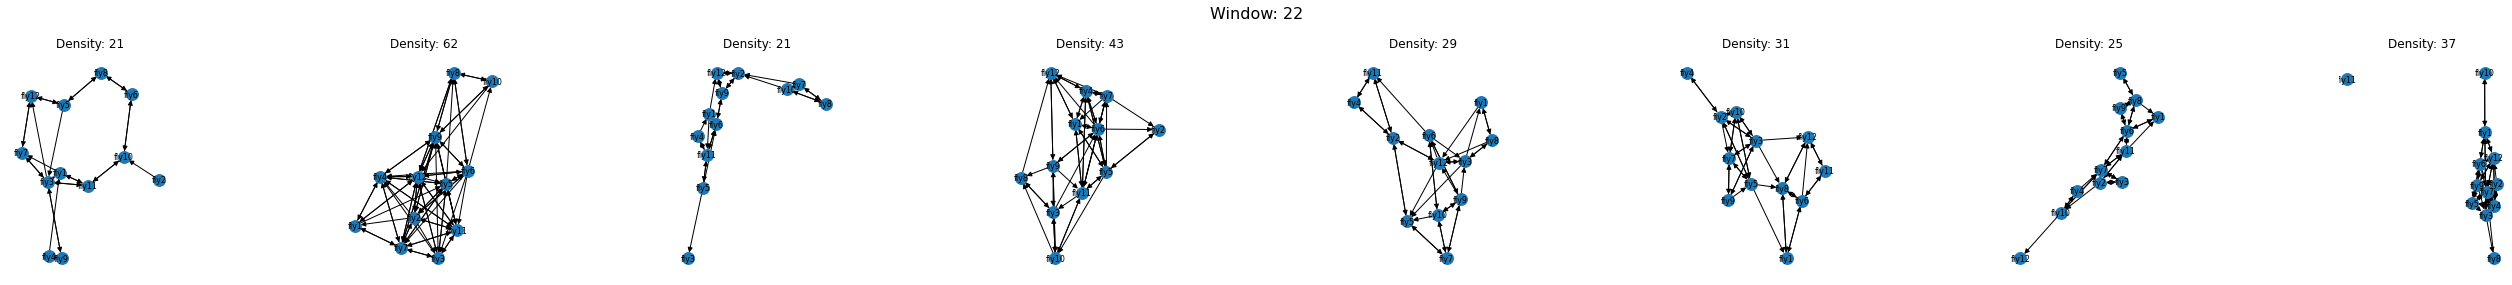

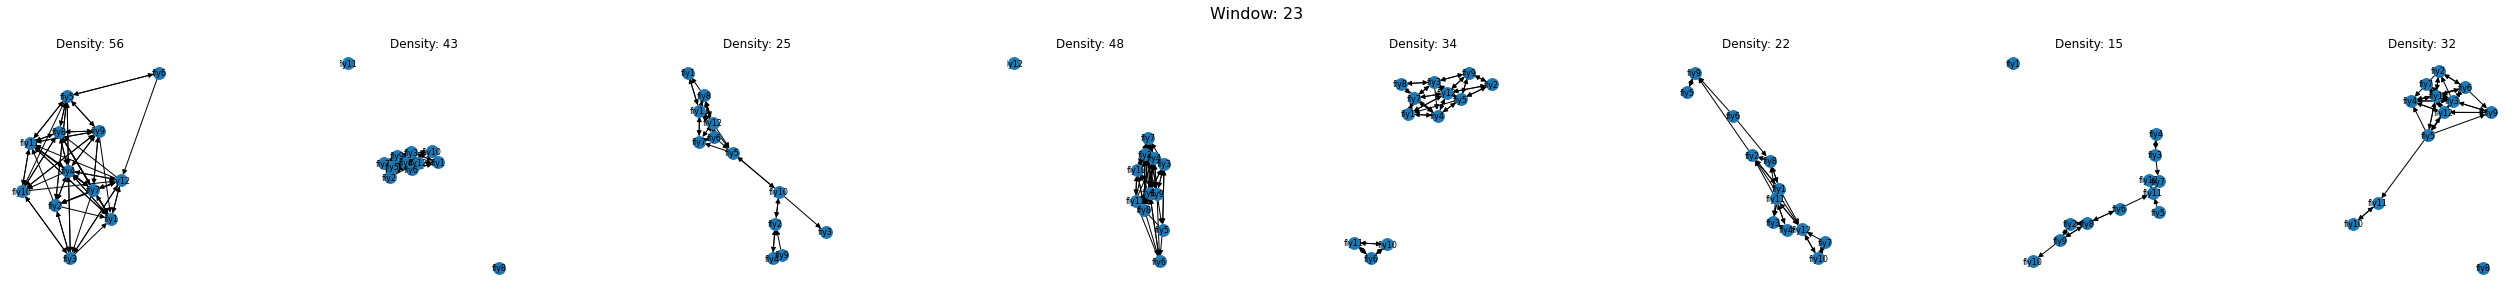

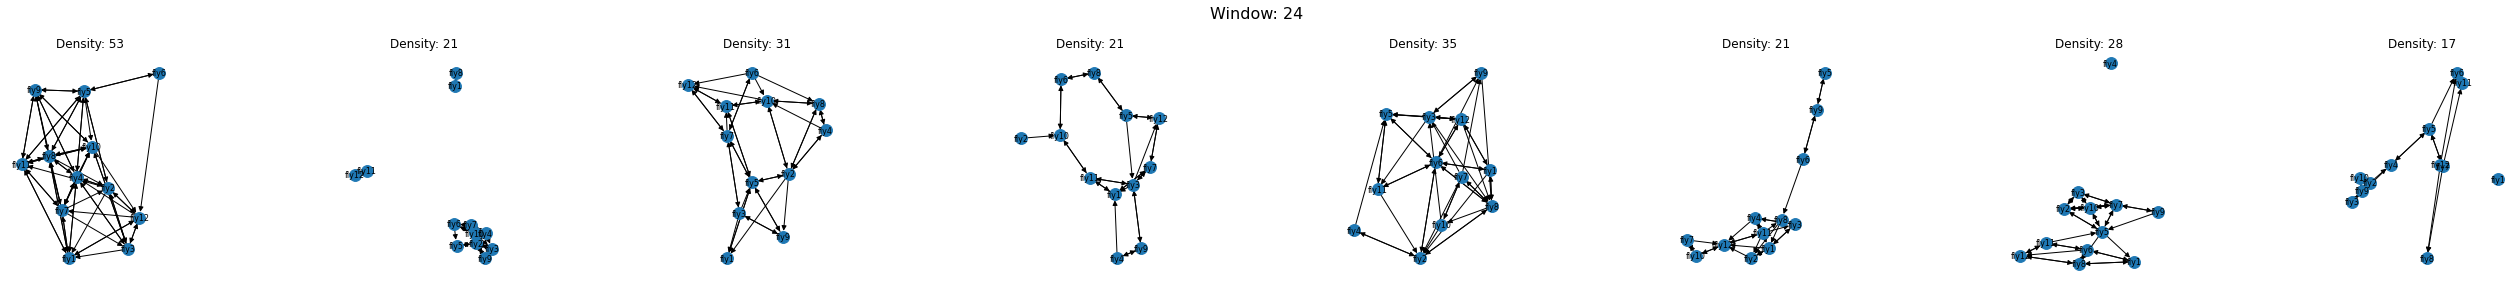

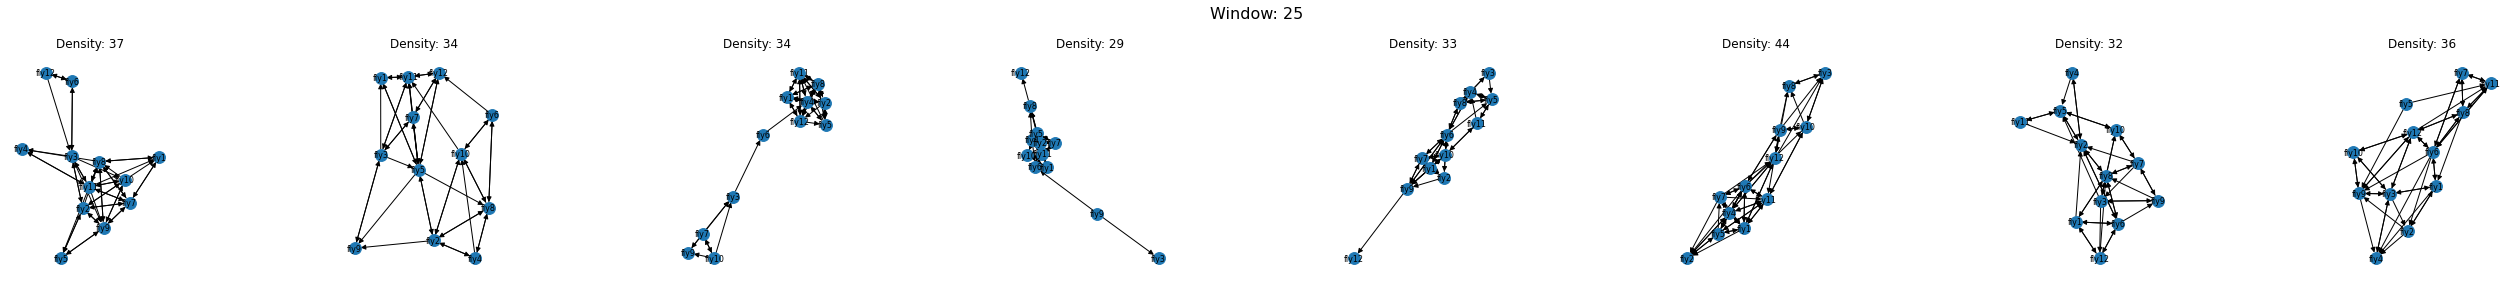

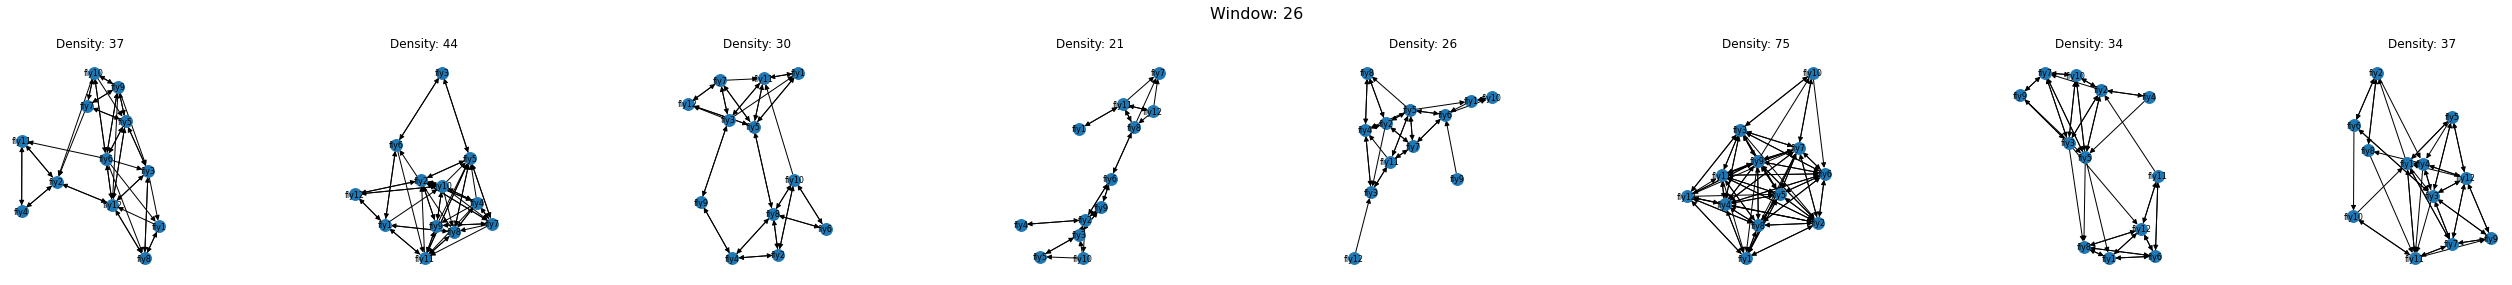

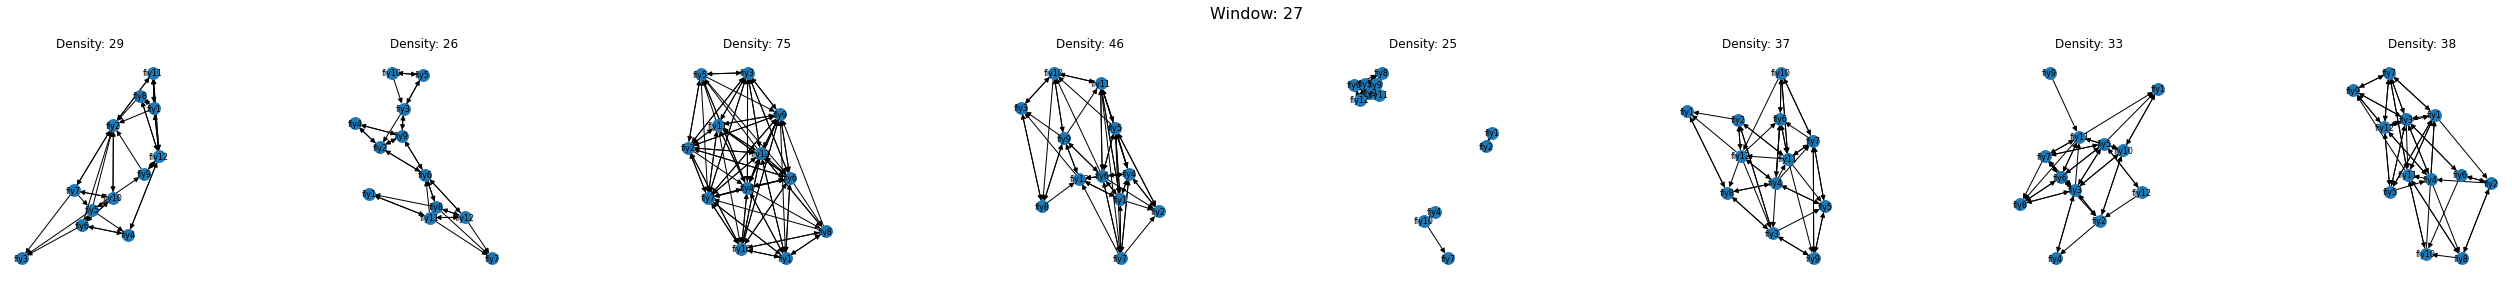

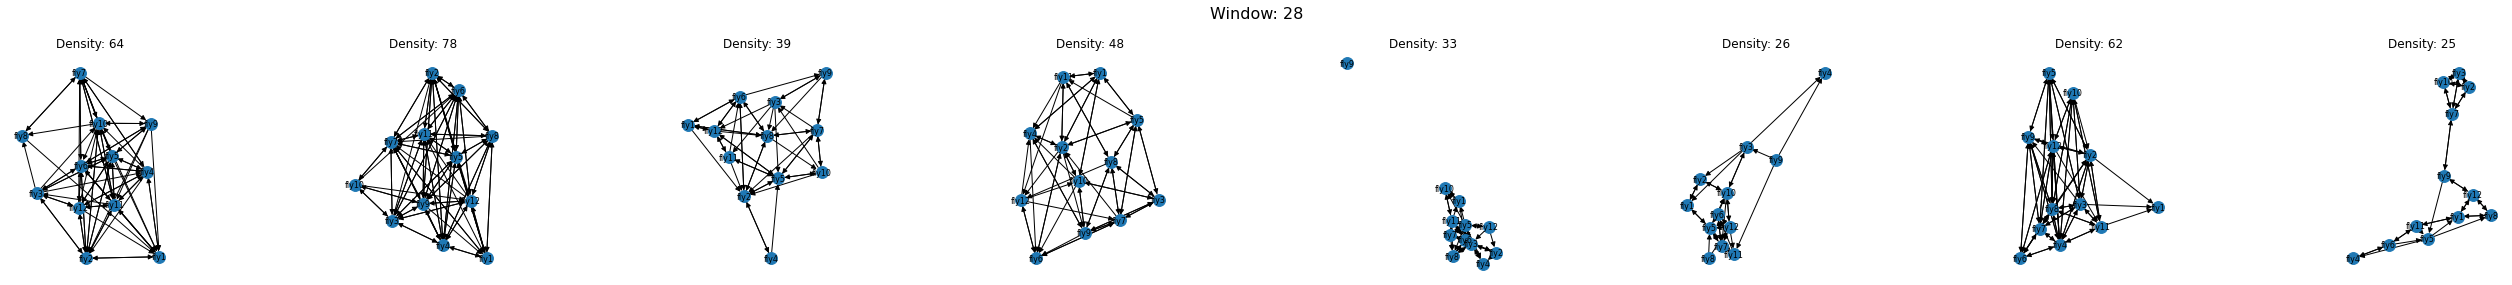

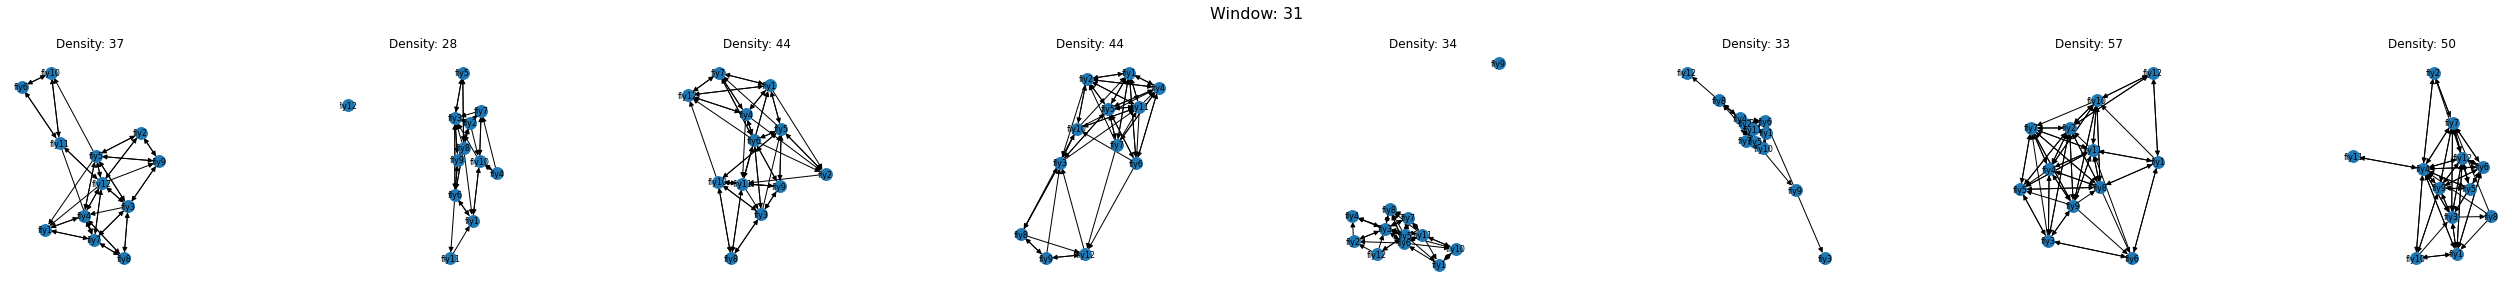

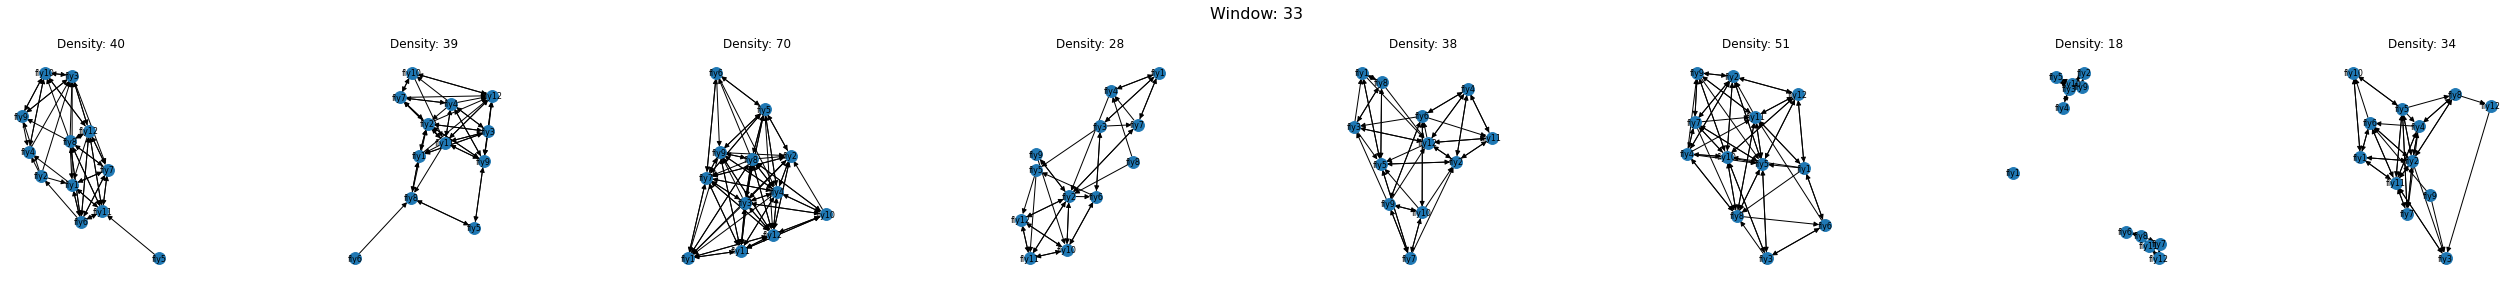

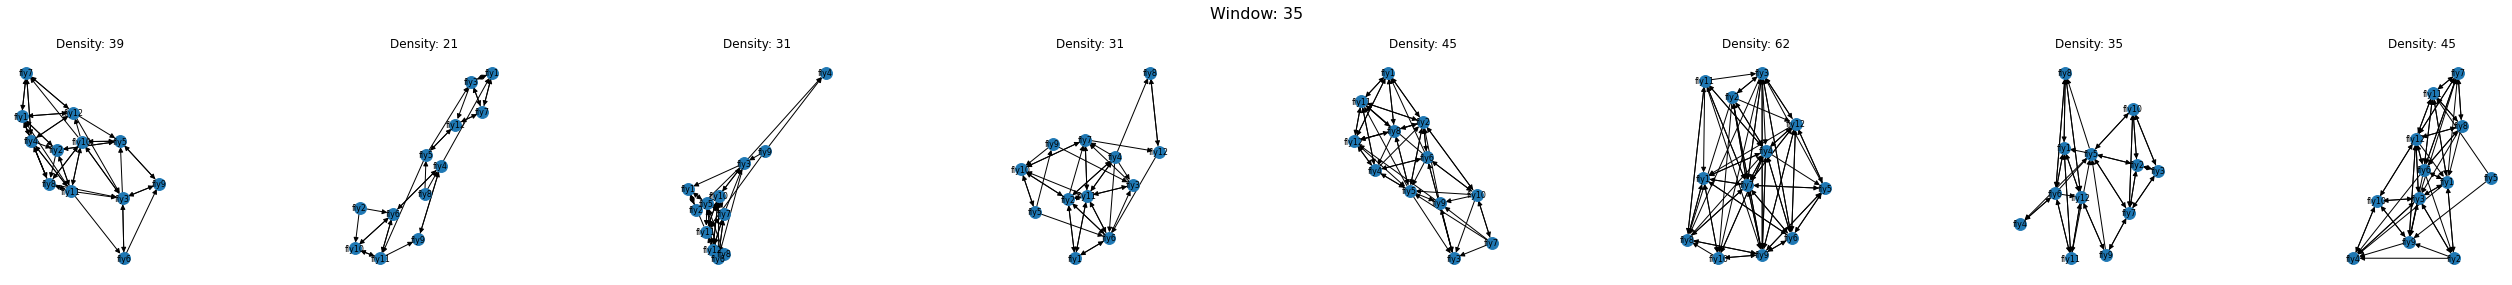

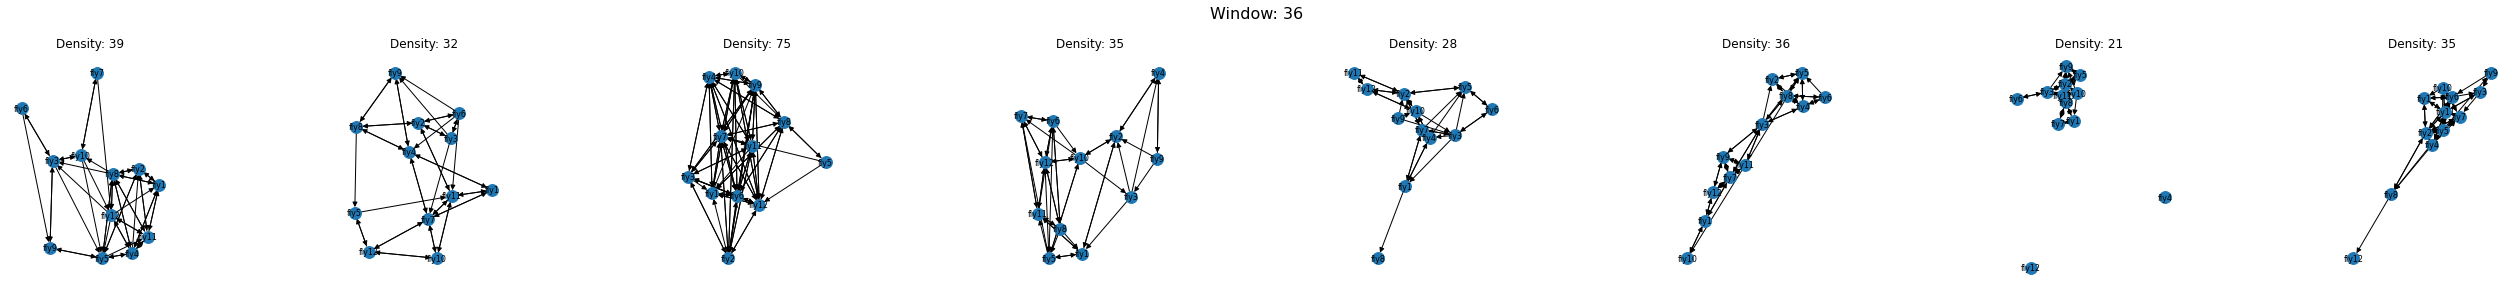

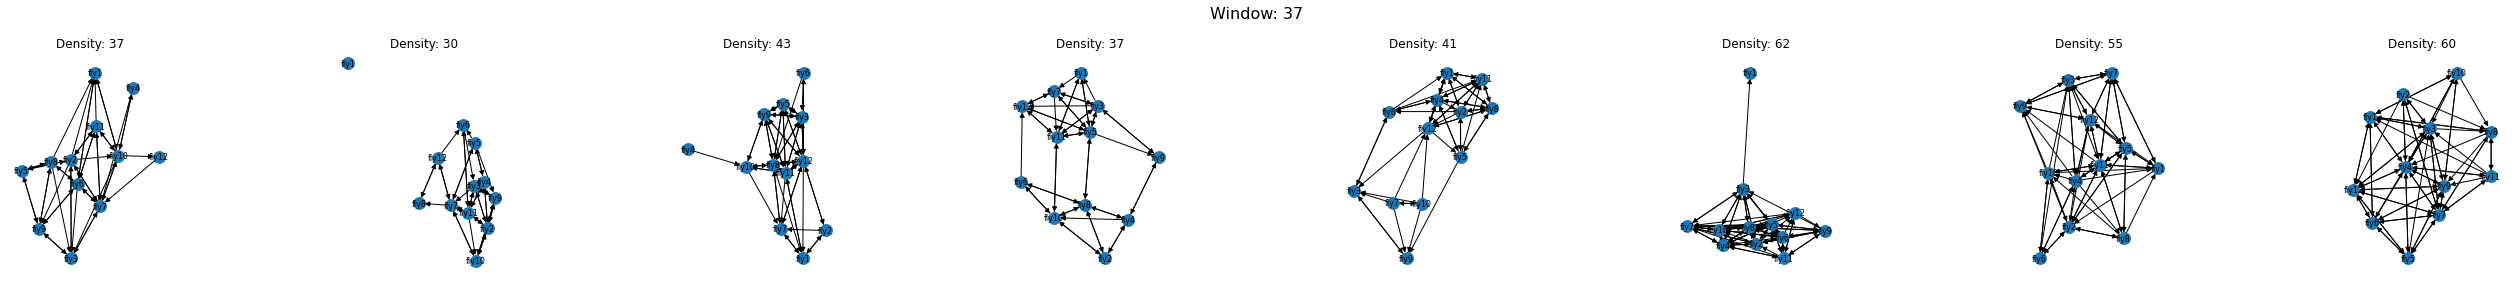

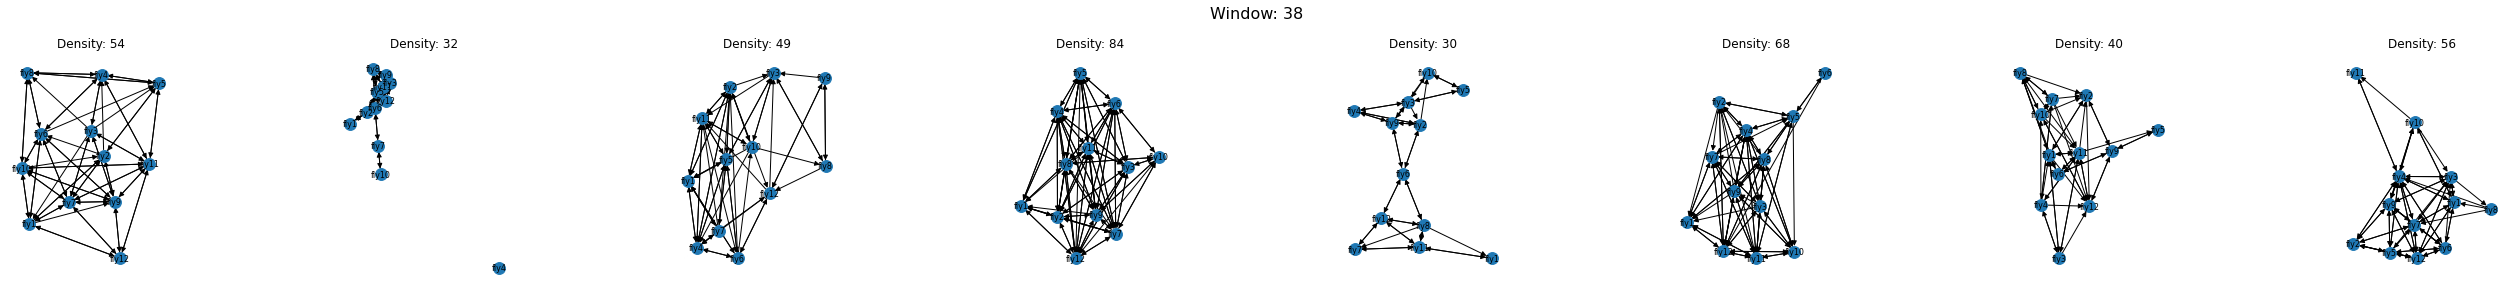

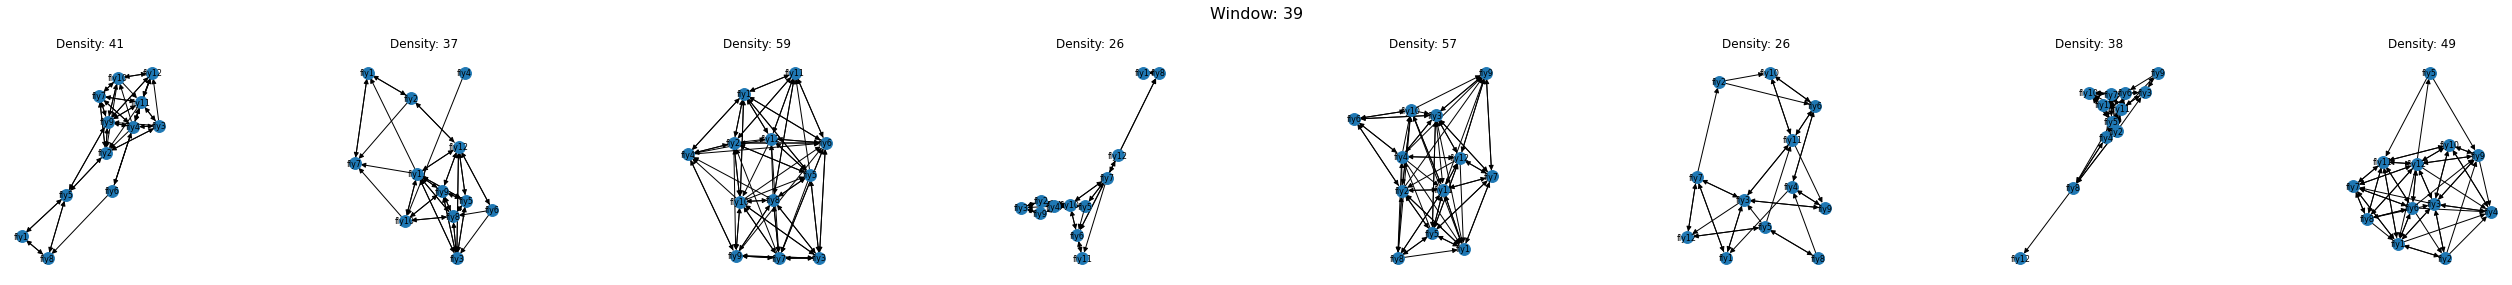

In [37]:
import matplotlib.pyplot as plt
import random

for window, all_graphs in all_graph_objects.items():
    sampled_graphs = random.sample(all_graphs, 8)
    fig, axs = plt.subplots(1, 8, figsize=(35, 4))  # Adjust size as needed
    fig.suptitle(f'Window: {window}', fontsize=16)
    
    for i, graph in enumerate(sampled_graphs):
        ax = axs[i]
        nx.draw(graph, ax=ax, with_labels=True, node_size=140, font_size=8)
        ax.set_title(f'Density: {int(nx.density(graph)*100)}')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=1)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx  # Assuming you're using NetworkX
import math

window_index = 13
graphs = all_graph_objects[window_index]

# graphs = [
#     g for g in graphs
#     if nx.is_connected(g.to_undirected()) and all(d > 0 for _, d in g.degree())
# ]

# graphs = graphs[:-1]

num_graphs = len(graphs)
cols = 7
rows = math.ceil(num_graphs / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))  # Adjust sizing as needed
fig.suptitle(f'Window: {window_index}', fontsize=16)

# Ensure axs is always a 2D list
axs = axs.reshape(-1, cols) if rows > 1 else [axs]

for i, graph in enumerate(graphs):
    row = i // cols
    col = i % cols
    ax = axs[row][col]
    pos = nx.spring_layout(graph, seed=42, k=0.8, scale=2.0)
    nx.draw(graph, ax=ax, pos=pos, with_labels=True, node_size=500, font_size=18, arrowsize=22)
    ax.set_title(f'Density: {int(nx.density(graph)*100)}')

# Hide any unused subplots
for j in range(num_graphs, rows * cols):
    row = j // cols
    col = j % cols
    axs[row][col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.25)
plt.savefig('graphs2.png', dpi=500)
plt.show()


In [8]:

len(all_graph_objects[13])

93